#Import Library and Dataset

In [ ]:
!pip install tensorflow # Installs TensorFlow library
!pip install keras # Installs keras library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import os
from datetime import datetime

%matplotlib inline

In [ ]:
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


#Prepare Data

In [ ]:
train_path = "/content/gdrive/MyDrive/265AiDataset/train"
test_path = "/content/gdrive/MyDrive/265AiDataset/test"
valid_path = "/content/gdrive/MyDrive/265AiDataset/valid"

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CLASS_SIZE = 6

In [ ]:
train_datagen = ImageDataGenerator(rescale=0)
train_generator = train_datagen.flow_from_directory(
        directory=train_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=0)
test_generator = test_datagen.flow_from_directory(
        directory=test_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle = False,
        class_mode='categorical')

valid_datagen = ImageDataGenerator(rescale=0)
valid_generator = valid_datagen.flow_from_directory(
        directory=valid_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle = False,
        class_mode='categorical')

Found 455 images belonging to 6 classes.
Found 188 images belonging to 6 classes.
Found 76 images belonging to 6 classes.


In [ ]:
class_names = train_generator.class_indices
class_names

{'long_sleeved_shirt': 0,
 'sandals': 1,
 'short_sleeved_shirt': 2,
 'shorts': 3,
 'sneakers': 4,
 'trousers': 5}

#Create Model

In [ ]:
import random
SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
data_augmentation = keras.Sequential([preprocessing.RandomRotation(0.0)], name ="data_augmentation")

In [ ]:
base_model = keras.applications.MobileNetV3Small(input_shape=(224, 224, 3),include_top=False, weights='imagenet') # Load the MobileNetV3Small model
base_model.trainable = True # Enable to train Pre-Trained Model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer") # Define input layer

4334752/4334752 [==============================] - 0s 0us/step


In [ ]:
x = data_augmentation(inputs) # Apply Augmentation to the input images. this use for decrease overfit
x = base_model(x, training=False) # Pass Augmentation Data to base_model
x = layers.GlobalAveragePooling2D(name="GloPool")(x) # Create Global Average Pooling and input x to get output tensor that value = Dense's filter. this use for decrease feature map
outputs = tf.keras.layers.Dense(CLASS_SIZE, activation="softmax", name="output_layer")(x) # output layer that (output unit = CLASS_SIZE as image class, activation function is softmax  )
model_0 = tf.keras.Model(inputs, outputs) # Create Model name model_0 that have input layer, base mosel, output layer
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"]) #Compile model_0 with categorical_crossentropy, adam's learning rate = 0.0001, metric by accuracy

In [ ]:
custom_early_stopping = EarlyStopping( # EarlyStopping is keras's callback function that stop training model before overfitting
    monitor='val_loss', # monitor at validation loss
    patience=10,
    min_delta=0.001, # if validation loss is not decrease at least 0.001 in 10 time
    mode='min' # need validtion loss to decrease
)

#Train Model

In [ ]:
start = datetime.now()

history = model_0.fit(train_generator, # Use from train generator
           epochs=30, # training round
           workers=0,
           steps_per_epoch=len(train_generator), # Use from batch size that can update each epoch for training
           validation_data=valid_generator, # Use from test generator
           validation_steps=len(valid_generator), # 25% of test data
           callbacks=[custom_early_stopping]) # Stop training when overfitting

print ('Execution Time: ',datetime.now()-start)

Epoch 1/30
15/15 [==============================] - 149s 7s/step - loss: 1.7027 - accuracy: 0.3560 - val_loss: 1.3666 - val_accuracy: 0.5395
Epoch 2/30
15/15 [==============================] - 2s 133ms/step - loss: 0.9178 - accuracy: 0.7165 - val_loss: 0.9172 - val_accuracy: 0.7500
Epoch 3/30
15/15 [==============================] - 3s 193ms/step - loss: 0.5105 - accuracy: 0.8462 - val_loss: 0.6567 - val_accuracy: 0.8289
Epoch 4/30
15/15 [==============================] - 2s 157ms/step - loss: 0.2709 - accuracy: 0.9297 - val_loss: 0.5226 - val_accuracy: 0.8289
Epoch 5/30
15/15 [==============================] - 2s 143ms/step - loss: 0.1460 - accuracy: 0.9714 - val_loss: 0.4597 - val_accuracy: 0.8289
Epoch 6/30
15/15 [==============================] - 2s 141ms/step - loss: 0.0798 - accuracy: 0.9890 - val_loss: 0.3990 - val_accuracy: 0.8684
Epoch 7/30
15/15 [==============================] - 2s 139ms/step - loss: 0.0434 - accuracy: 0.9978 - val_loss: 0.4139 - val_accuracy: 0.8158
Epoch 8

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, None)  0        
 al)                                                             
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 GloPool (GlobalAveragePooli  (None, 576)              0         
 ng2D)                                                           
                                                                 
 output_layer (Dense)        (None, 6)                 3462      
                                                             

In [ ]:
# Evaluate the model on the test set

test_loss, test_acc = model_0.evaluate_generator(test_generator, steps=len(test_generator))
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

<ipython-input-15-6717daddbeb4>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model_0.evaluate_generator(test_generator, steps=len(test_generator))


Test loss: 1.2017277479171753
Test accuracy: 0.6808510422706604


#Evaluate Model

In [ ]:
model_0.evaluate(test_generator)

6/6 [==============================] - 1s 126ms/step - loss: 1.2017 - accuracy: 0.6809


[1.2017277479171753, 0.6808510422706604]

In [ ]:
# Evaluate the model on the test set
start = datetime.now()
test_loss, test_acc = model_0.evaluate_generator(test_generator, steps=len(test_generator))
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test Time:',datetime.now()-start)

<ipython-input-17-0897c54d69da>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model_0.evaluate_generator(test_generator, steps=len(test_generator))


Test loss: 1.2017277479171753
Test accuracy: 0.6808510422706604
Test Time: 0:00:01.448563


6/6 [==============================] - 2s 99ms/step


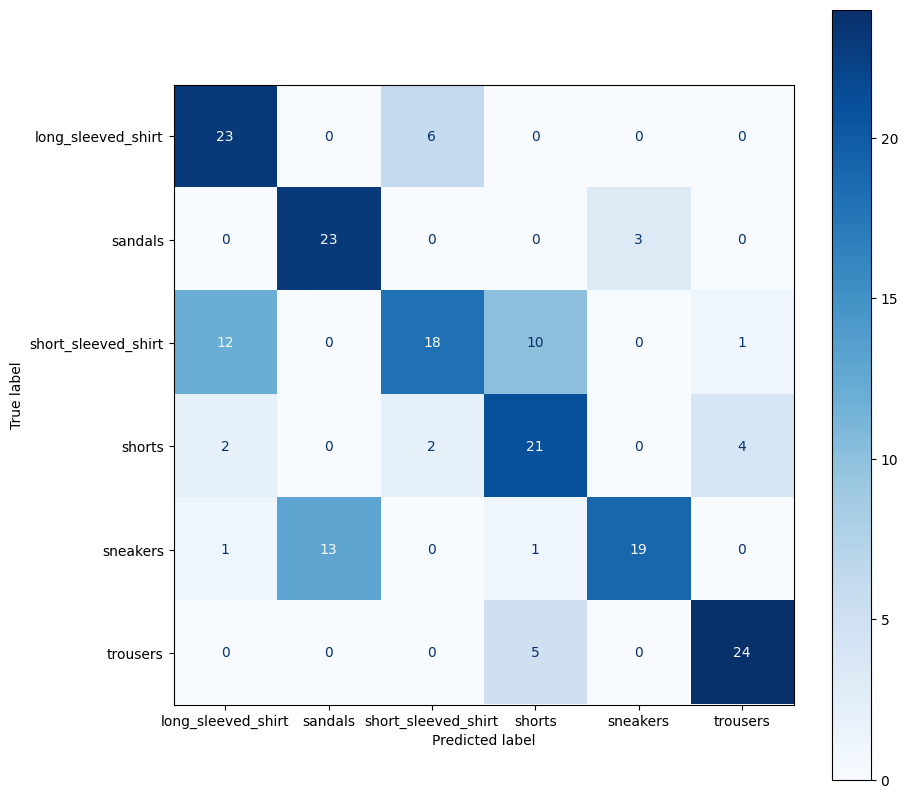

class  specificity  sensitivity
0      0     0.905660     0.793103
1      1     0.919753     0.884615
2      2     0.945578     0.439024
3      3     0.899371     0.724138
4      4     0.980519     0.558824
5      5     0.968553     0.827586

In [ ]:
import sklearn as scikit_learn
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

test_true=test_generator.classes[test_generator.index_array]
test_pred_raw = model_0.predict(test_generator)
test_pred = np.argmax(test_pred_raw, axis=1)

cm = confusion_matrix(test_true, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()


res = []
for l in [0,1,2,3,4,5]:
    pres,recall,_,_ = precision_recall_fscore_support(np.array(test_true)==l,np.array(test_pred)==l,pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','specificity','sensitivity'])

In [ ]:
from sklearn.metrics import classification_report


report = classification_report(test_true, test_pred,target_names=class_names)
print(report)

                     precision    recall  f1-score   support

 long_sleeved_shirt       0.61      0.79      0.69        29
            sandals       0.64      0.88      0.74        26
short_sleeved_shirt       0.69      0.44      0.54        41
             shorts       0.57      0.72      0.64        29
           sneakers       0.86      0.56      0.68        34
           trousers       0.83      0.83      0.83        29

           accuracy                           0.68       188
          macro avg       0.70      0.70      0.68       188
       weighted avg       0.70      0.68      0.67       188



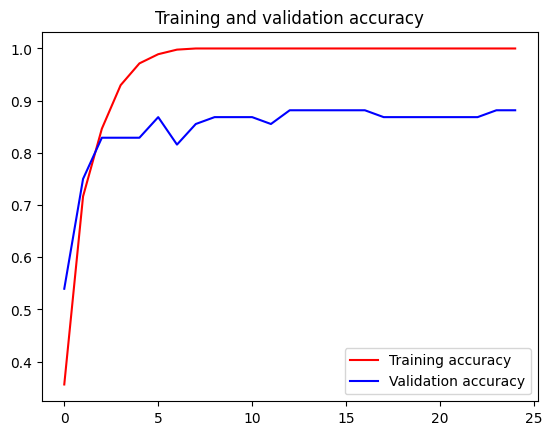

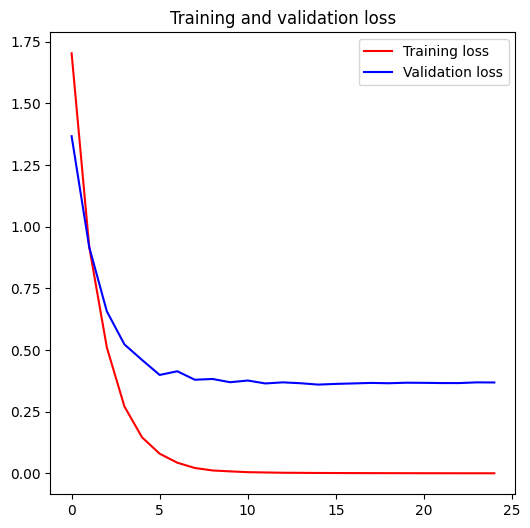

<Figure size 600x600 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure(figsize=(6,6))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure(figsize=(6,6))

plt.show()


#Test with real  image

In [ ]:
import os

# Path to the folder containing images to predict
folder_path = "/content/gdrive/MyDrive/for_test"

1/1 [==============================] - 1s 916ms/step
Image name: 1(114).jpg
Predicted class: long_sleeved_shirt (99.36%)
Prediction:  ['99.36%', '0.09%', '0.35%', '0.19%', '0.00%', '0.00%']


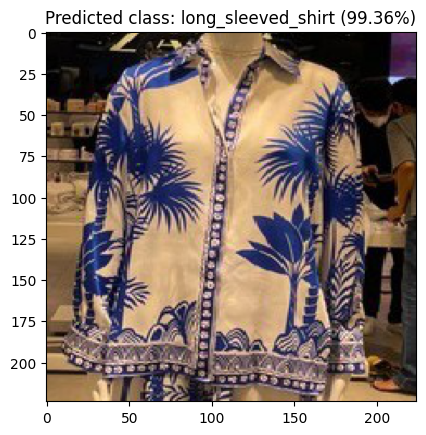



1/1 [==============================] - 0s 40ms/step
Image name: 1(115).jpg
Predicted class: long_sleeved_shirt (99.99%)
Prediction:  ['99.99%', '0.00%', '0.01%', '0.00%', '0.00%', '0.00%']


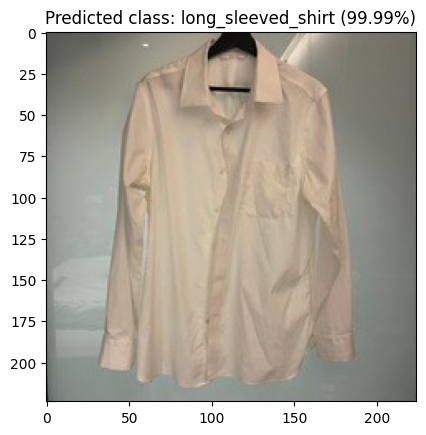



1/1 [==============================] - 0s 26ms/step
Image name: 1(118).jpg
Predicted class: short_sleeved_shirt (91.16%)
Prediction:  ['6.98%', '0.00%', '91.16%', '1.56%', '0.17%', '0.13%']


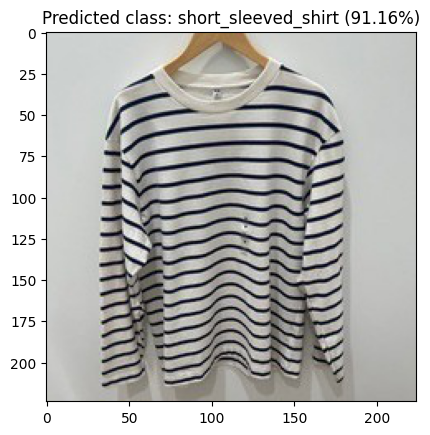



1/1 [==============================] - 0s 25ms/step
Image name: 1(116).jpg
Predicted class: long_sleeved_shirt (99.99%)
Prediction:  ['99.99%', '0.00%', '0.01%', '0.00%', '0.00%', '0.00%']


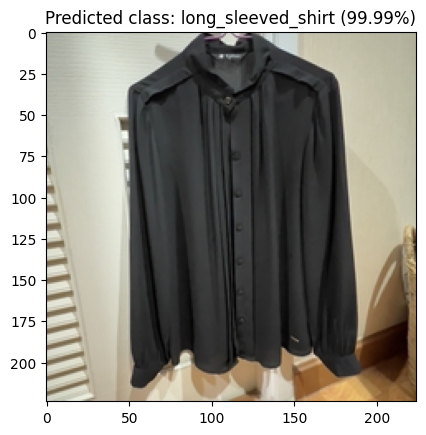



1/1 [==============================] - 0s 36ms/step
Image name: 1(117).jpg
Predicted class: long_sleeved_shirt (99.93%)
Prediction:  ['99.93%', '0.00%', '0.00%', '0.00%', '0.00%', '0.07%']


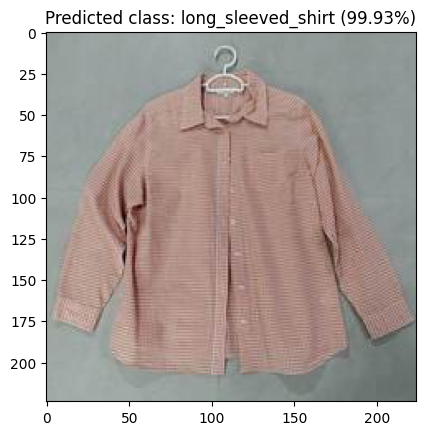



1/1 [==============================] - 0s 26ms/step
Image name: 2 (156).jpg
Predicted class: short_sleeved_shirt (100.00%)
Prediction:  ['0.00%', '0.00%', '100.00%', '0.00%', '0.00%', '0.00%']


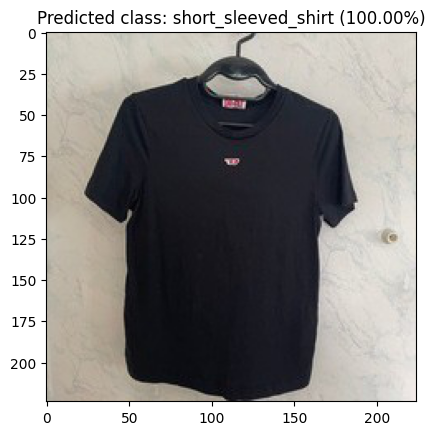



1/1 [==============================] - 0s 25ms/step
Image name: 2 (162).jpg
Predicted class: short_sleeved_shirt (99.76%)
Prediction:  ['0.20%', '0.00%', '99.76%', '0.00%', '0.00%', '0.05%']


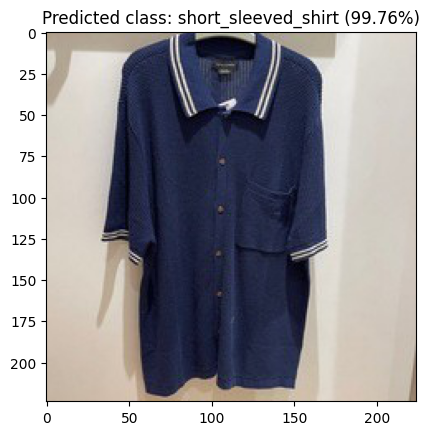



1/1 [==============================] - 0s 25ms/step
Image name: 2 (161).jpg
Predicted class: short_sleeved_shirt (99.48%)
Prediction:  ['0.52%', '0.00%', '99.48%', '0.00%', '0.00%', '0.00%']


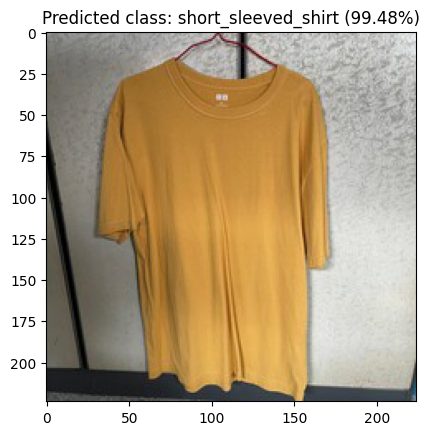



1/1 [==============================] - 0s 25ms/step
Image name: 2 (157).jpg
Predicted class: short_sleeved_shirt (100.00%)
Prediction:  ['0.00%', '0.00%', '100.00%', '0.00%', '0.00%', '0.00%']


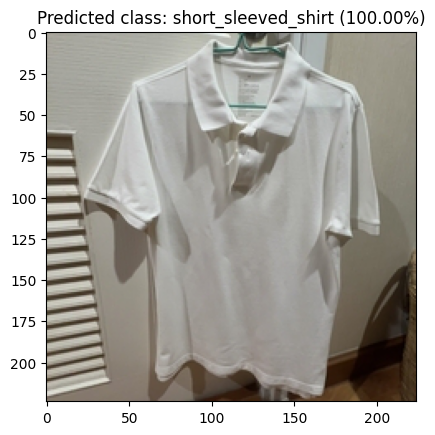



1/1 [==============================] - 0s 23ms/step
Image name: 2 (158).jpg
Predicted class: short_sleeved_shirt (99.30%)
Prediction:  ['0.11%', '0.00%', '99.30%', '0.59%', '0.00%', '0.00%']


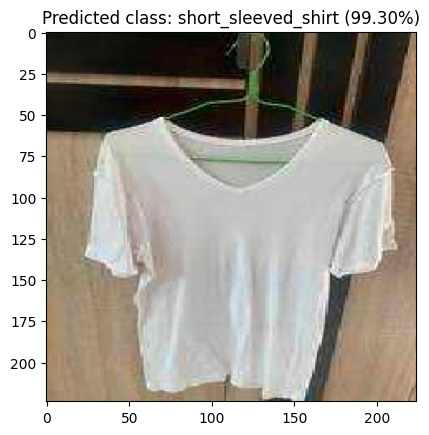



1/1 [==============================] - 0s 25ms/step
Image name: 2 (159).jpg
Predicted class: short_sleeved_shirt (97.17%)
Prediction:  ['2.10%', '0.07%', '97.17%', '0.61%', '0.00%', '0.04%']


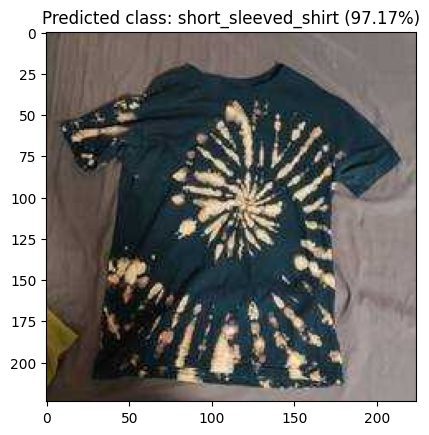



1/1 [==============================] - 0s 40ms/step
Image name: 2 (160).jpg
Predicted class: short_sleeved_shirt (89.71%)
Prediction:  ['0.40%', '1.94%', '89.71%', '0.13%', '7.82%', '0.00%']


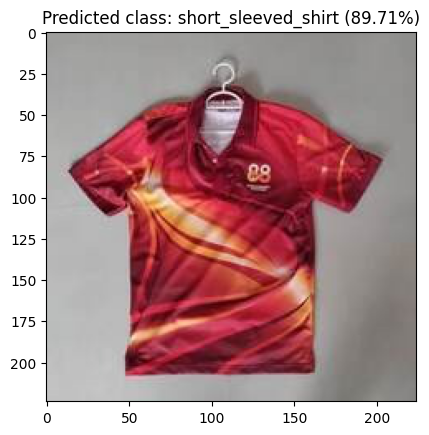



1/1 [==============================] - 0s 36ms/step
Image name: 3 (113).jpg
Predicted class: trousers (99.64%)
Prediction:  ['0.35%', '0.00%', '0.00%', '0.01%', '0.00%', '99.64%']


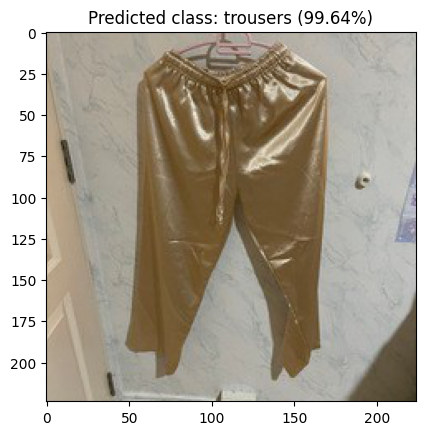



1/1 [==============================] - 0s 34ms/step
Image name: 3 (114).jpg
Predicted class: trousers (100.00%)
Prediction:  ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '100.00%']


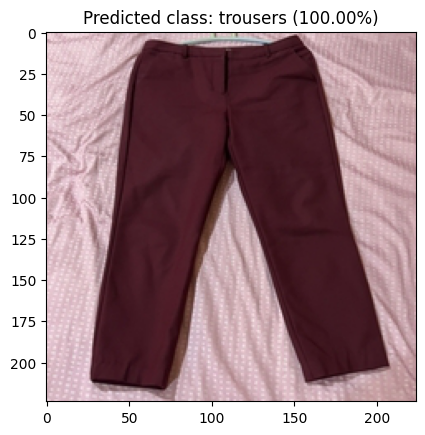



1/1 [==============================] - 0s 36ms/step
Image name: 3 (115).jpg
Predicted class: trousers (99.79%)
Prediction:  ['0.16%', '0.00%', '0.00%', '0.05%', '0.00%', '99.79%']


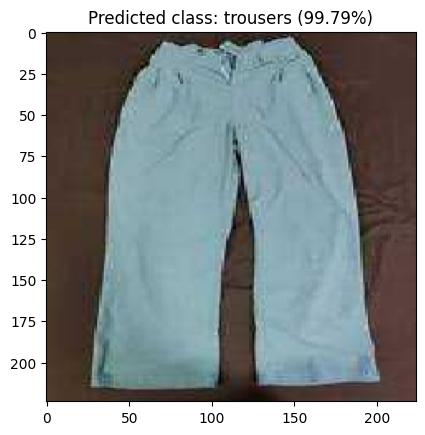



1/1 [==============================] - 0s 46ms/step
Image name: 3 (117).jpg
Predicted class: trousers (99.97%)
Prediction:  ['0.02%', '0.00%', '0.01%', '0.00%', '0.00%', '99.97%']


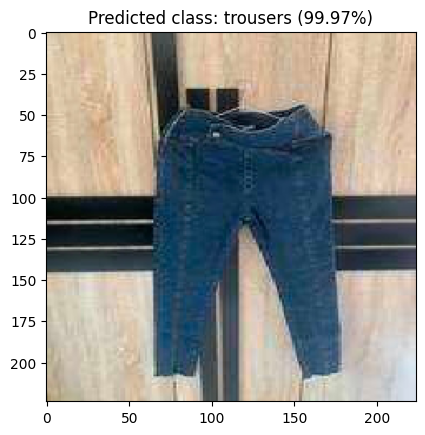



1/1 [==============================] - 0s 46ms/step
Image name: 3 (116).jpg
Predicted class: trousers (73.07%)
Prediction:  ['26.82%', '0.01%', '0.01%', '0.09%', '0.00%', '73.07%']


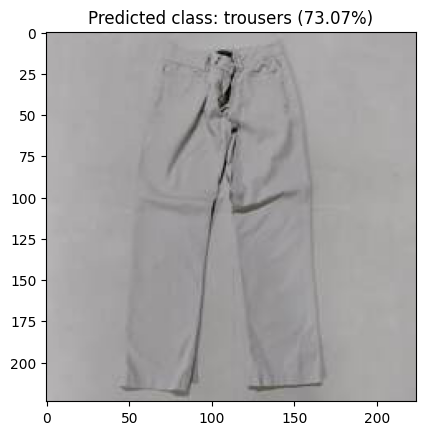



1/1 [==============================] - 0s 24ms/step
Image name: 4 (115).jpg
Predicted class: shorts (100.00%)
Prediction:  ['0.00%', '0.00%', '0.00%', '100.00%', '0.00%', '0.00%']


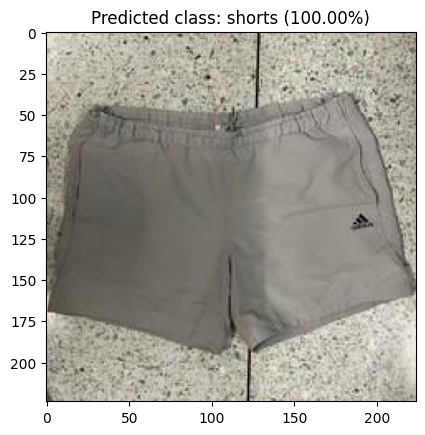



1/1 [==============================] - 0s 26ms/step
Image name: 4 (112).jpg
Predicted class: shorts (98.28%)
Prediction:  ['1.69%', '0.00%', '0.00%', '98.28%', '0.00%', '0.02%']


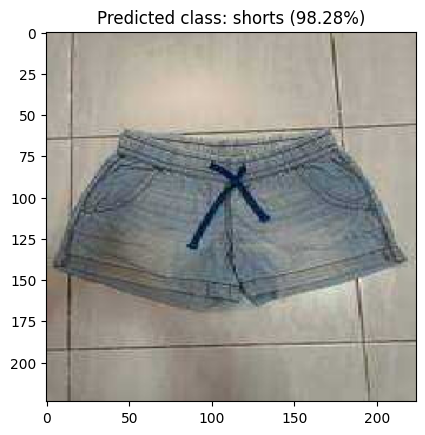



1/1 [==============================] - 0s 25ms/step
Image name: 4 (116).jpg
Predicted class: shorts (99.93%)
Prediction:  ['0.01%', '0.00%', '0.05%', '99.93%', '0.00%', '0.00%']


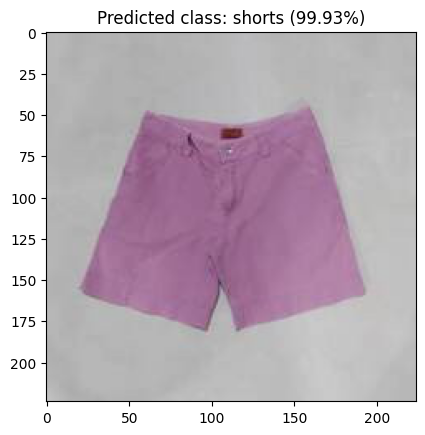



1/1 [==============================] - 0s 25ms/step
Image name: 4 (113).jpg
Predicted class: shorts (99.93%)
Prediction:  ['0.00%', '0.00%', '0.01%', '99.93%', '0.00%', '0.06%']


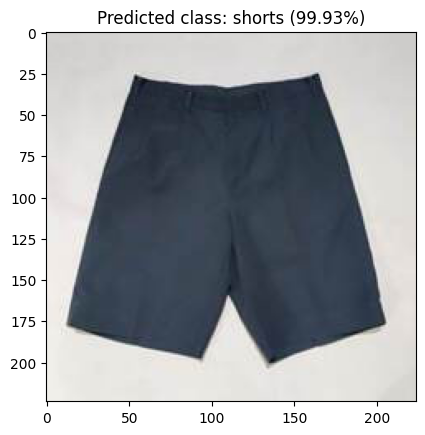



1/1 [==============================] - 0s 27ms/step
Image name: 4 (114).jpg
Predicted class: shorts (99.89%)
Prediction:  ['0.01%', '0.00%', '0.00%', '99.89%', '0.00%', '0.10%']


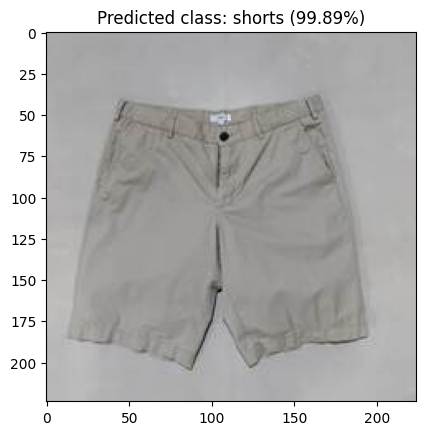



1/1 [==============================] - 0s 25ms/step
Image name: 5 (103).jpg
Predicted class: sandals (98.43%)
Prediction:  ['0.02%', '98.43%', '0.00%', '0.00%', '1.54%', '0.01%']


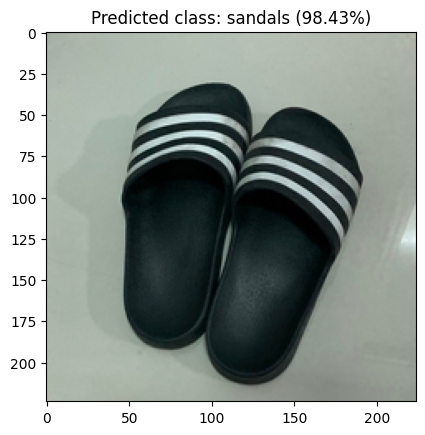



1/1 [==============================] - 0s 24ms/step
Image name: 5 (102).jpg
Predicted class: sandals (99.98%)
Prediction:  ['0.00%', '99.98%', '0.00%', '0.00%', '0.01%', '0.00%']


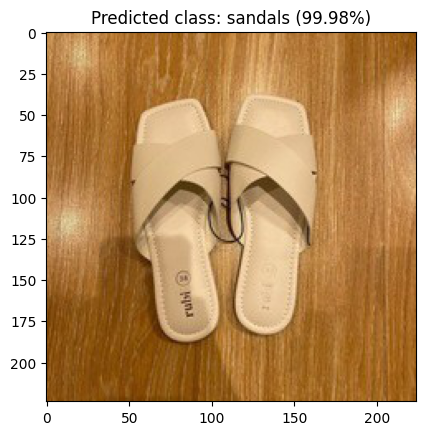



1/1 [==============================] - 0s 34ms/step
Image name: 5 (101).jpg
Predicted class: sandals (85.30%)
Prediction:  ['0.00%', '85.30%', '0.18%', '0.00%', '14.51%', '0.01%']


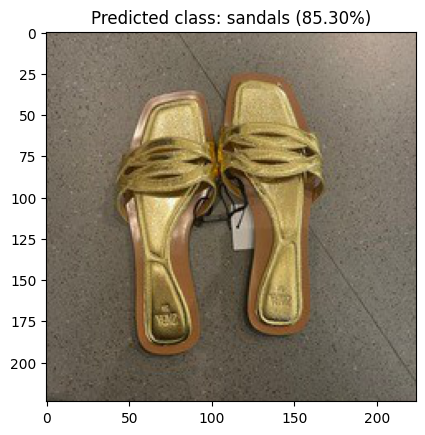



1/1 [==============================] - 0s 24ms/step
Image name: 5 (104).jpg
Predicted class: sandals (96.24%)
Prediction:  ['0.00%', '96.24%', '0.00%', '0.00%', '0.03%', '3.73%']


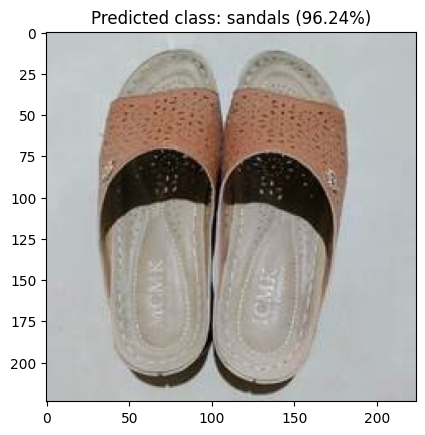



1/1 [==============================] - 0s 27ms/step
Image name: 5 (100).jpg
Predicted class: sandals (96.66%)
Prediction:  ['0.00%', '96.66%', '0.00%', '0.02%', '1.22%', '2.10%']


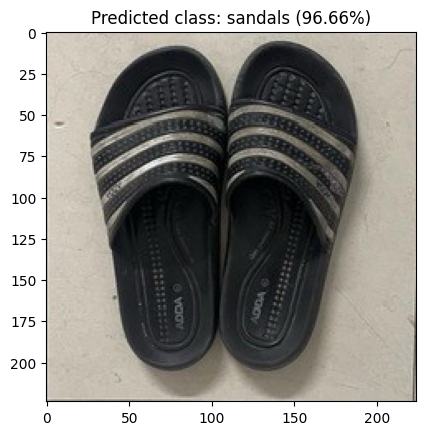



1/1 [==============================] - 0s 26ms/step
Image name: 6 (134).jpg
Predicted class: sneakers (98.68%)
Prediction:  ['0.00%', '0.46%', '0.00%', '0.00%', '98.68%', '0.85%']


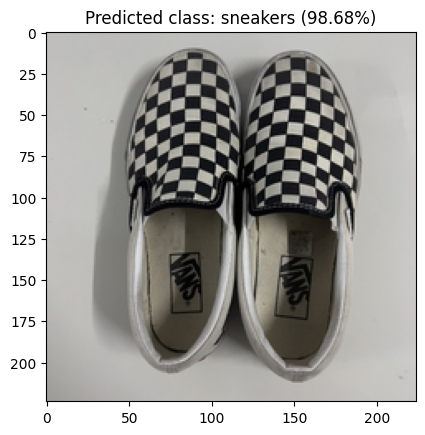



1/1 [==============================] - 0s 27ms/step
Image name: 6 (132).jpg
Predicted class: sneakers (99.92%)
Prediction:  ['0.01%', '0.06%', '0.00%', '0.00%', '99.92%', '0.01%']


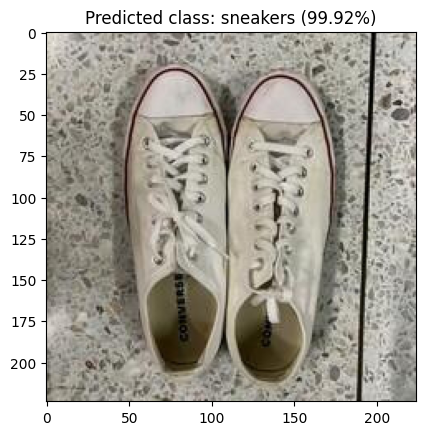



1/1 [==============================] - 0s 44ms/step
Image name: 6 (131).jpg
Predicted class: sneakers (99.99%)
Prediction:  ['0.00%', '0.01%', '0.00%', '0.00%', '99.99%', '0.00%']


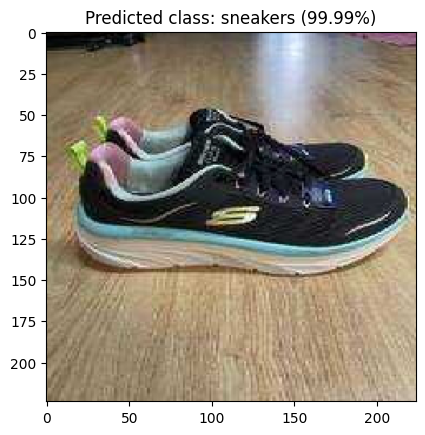



1/1 [==============================] - 0s 25ms/step
Image name: 6 (130).jpg
Predicted class: sandals (84.82%)
Prediction:  ['0.01%', '84.82%', '0.00%', '0.00%', '15.07%', '0.10%']


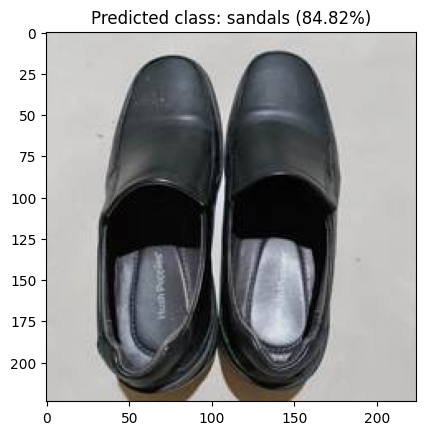



1/1 [==============================] - 0s 32ms/step
Image name: 6 (133).jpg
Predicted class: sneakers (99.99%)
Prediction:  ['0.00%', '0.01%', '0.00%', '0.00%', '99.99%', '0.00%']


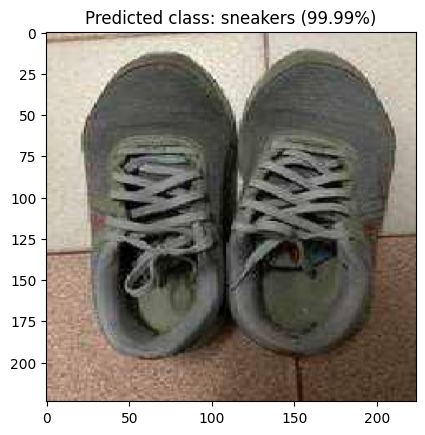

In [ ]:
# Loop through each image in the folder
for filename in os.listdir(folder_path):
    # Load the image
    img_path = os.path.join(folder_path, filename)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)

    # Make prediction
    prediction = model_0.predict(img_array)
    class_names = train_generator.class_indices
    class_names = {v: k for k, v in class_names.items()} # reverse the class_indices dictionary
    predicted_class = np.argmax(prediction, axis=1)
    predicted_class_name = class_names[predicted_class[0]]
    predicted_prob = np.max(prediction, axis=1)

    # Print the result
    print("Image name:", filename)
    print("Predicted class: {} ({:.2f}%)".format(predicted_class_name, predicted_prob[0]*100))
    prediction_list = prediction.tolist() # Convert the NumPy array to a Python list
    prediction_formatted = ["{:.2%}".format(p) for p in prediction_list[0]]
    print("Prediction: ", prediction_formatted)
    plt.imshow(img)
    plt.title("Predicted class: {} ({:.2f}%)".format(predicted_class_name, predicted_prob[0]*100))
    plt.show()
    print("\n")